In [1]:
import os
import sys
import logging
# import glob
# import time
# import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

## Custom packages
import iXAtom_Class_Physics       as iXC_Physics
import iXAtom_Class_RunParameters as iXC_RunPars
import iXAtom_Class_Detector      as iXC_Detect
import iXAtom_Class_Ramsey        as iXC_Ramsey
import iXAtom_Utilities           as iXUtils

# For inline plots
%matplotlib inline
# Reload IPython extension 'autoreload'
%reload_ext autoreload
# autoreload: Reload all modules (except those excluded by %aimport) automatically now
# autoreload 0: Disable automatic reloading of modules
# autoreload 1: Reload all modules imported with %aimport every time before executing
# autoreload 2: Reload all modules (except those excluded by %aimport) every time before executing
%autoreload 1

%aimport iXAtom_Class_Physics
%aimport iXAtom_Class_RunParameters
%aimport iXAtom_Class_Detector
%aimport iXAtom_Class_Ramsey
%aimport iXAtom_Utilities

logging.disable(level=logging.NOTSET)

iXUtils.SetDefaultPlotOptions()

In [2]:
# RootDir = 'C:\\iXAtom Desktop\\Data 2020'
RootDir = 'C:\\Bryns Goodies\\Work-iXAtom\\Data 2020'
Date    = {'Month': 'October', 'Day': 2}
WorkDir = os.path.join(RootDir, Date['Month'], '{:02d}'.format(Date['Day']))
Folder  = 'Ramsey'
RunNum  = 1

RunPars = iXC_RunPars.RunParameters(WorkDir, Folder, RunNum)
RunPars.LoadRunParameters()

Physics = iXC_Physics.Physics(RunPars)
iaxList = RunPars.iaxList
ikList  = RunPars.ikList
keff    = RunPars.keff
gLocal  = RunPars.gLocal

pd.DataFrame(RunPars.__dict__.items())

,0,1
0,SoftwareVersion,3.4
1,Run,1
2,DataType,Ramsey
3,TrackProtocol,Two-Point kInterlaced
4,TrackMode,"Open Loop, Fixed Chirp"
...,...,...
101,nk,1
102,nax,3
103,FilePrefix,Ramsey
104,AxisFileLabels,"[X, Y, Z]"


-------- Tilt X = 0.0 deg --------
Slope  = (0.0421 +/- 0.0099) mG/mm
Offset = (0.149552 +/- 0.000055) G
-------- Tilt X = -30.0 deg --------
Slope  = (0.1209 +/- 0.0044) mG/mm
Offset = (0.147763 +/- 0.000021) G
-------- Tilt X = 30.0 deg --------
Slope  = (-0.0640 +/- 0.0215) mG/mm
Offset = (0.149300 +/- 0.000142) G
-------- Tilt X = 45.0 deg --------
Slope  = (-0.1617 +/- 0.0085) mG/mm
Offset = (0.148621 +/- 0.000056) G
-------- Tilt X = -44.0 deg --------
Slope  = (0.1809 +/- 0.0073) mG/mm
Offset = (0.146335 +/- 0.000040) G
-------- Tilt X = -60.0 deg --------
Slope  = (0.2683 +/- 0.0227) mG/mm
Offset = (0.144323 +/- 0.000111) G
-------- Tilt X = 60.0 deg --------
Slope  = (-0.2277 +/- 0.0130) mG/mm
Offset = (0.147502 +/- 0.000078) G


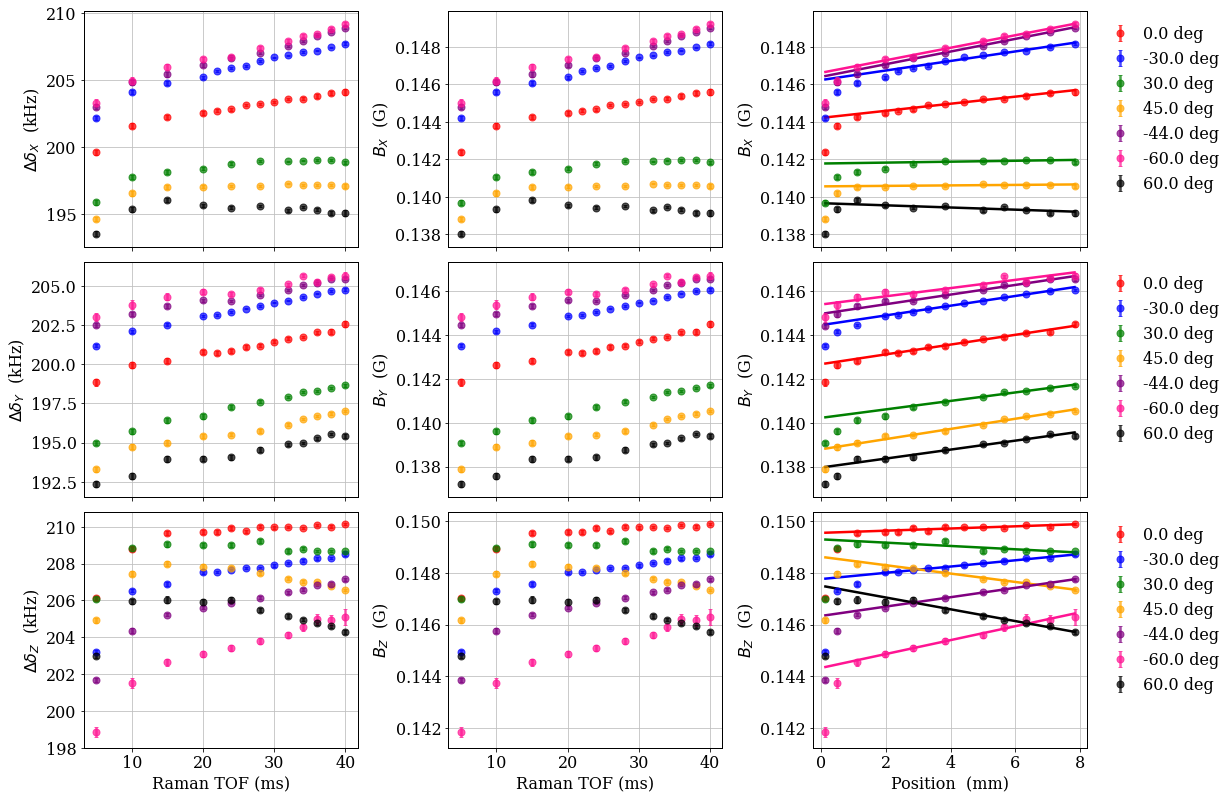

In [4]:
#========================================================================================= 
#  Plot analysis summary results for specific runs on specific days
#=========================================================================================
## Set plot options
plt.rc('font', size=16, family='serif')
plt.rc('axes', titlesize=12, labelsize=16, edgecolor='black', linewidth=1)
plt.rc('lines', linewidth=2.5, markersize=14)
plt.rc('legend', fontsize=16, frameon=False, handletextpad=0.4)

DateList = [{'Month': 'October', 'Day': 1}, {'Month': 'October', 'Day': 1}, 
            {'Month': 'October', 'Day': 2}, {'Month': 'October', 'Day': 2},
            {'Month': 'October', 'Day': 2}, {'Month': 'October', 'Day': 2}, {'Month': 'October', 'Day': 2}]
RunLists = [[81,94], [95,108], [1,11], [12,22], [23,33], [34,44], [45,55]]
nList    = len(RunLists)

TiltList = np.array([[360,-45], [330,-45], [30,-45], [45,-45], [316,-45], [300,-45], [60,-45]]) ## [X, Z] (deg)
TiltX    = [TiltList[r,0]-360 if TiltList[r,0] > 180 else TiltList[r,0] for r in range(nList)] ## (deg)
dBList   = np.zeros((3,2,nList)) ## iax, iErr, iRun
B0List   = np.zeros((3,2,nList)) ## iax, iErr, iRun
Colors   = ['red', 'blue', 'green', 'orange','purple','deeppink','black']
iStarts  = [4,4,4,4,4,4,4]

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(17,11), sharex='col', constrained_layout=True)

for r in range(nList):
    RunList = RunLists[r]
    WorkDir = os.path.join(RootDir, DateList[r]['Month'], '{:02d}'.format(DateList[r]['Day']))
    RunPars = iXC_RunPars.RunParameters(WorkDir, Folder, RunList[0])
    RunPars.LoadRunParameters()

    Physics = iXC_Physics.Physics(RunPars)

    SummaryFolder     = os.path.join(WorkDir, 'PostProcessed', Folder)
    SummaryFilePrefix = Folder + '-Runs{:02d}-{:02d}-AnalysisSummary-'.format(min(RunList), max(RunList))
    SummaryFilePaths  = [os.path.join(SummaryFolder, SummaryFilePrefix + RunPars.AxisFileLabels[iax][0] + '.txt') for iax in range(3)]

    SummaryDF = [pd.DataFrame([]) for iax in range(3)]

    for iax in iaxList:
        if os.path.exists(SummaryFilePaths[iax]):
            SummaryDF[iax] = pd.read_csv(SummaryFilePaths[iax], sep='\t')
        else:
            print('Summary file not found: {}'.format(SummaryFilePaths[iax]))

    ## Default plot options
    PlotOpts = {'Color': Colors[r], 'Linestyle': 'None', 'Marker': '.',
        'Title': 'None', 'xLabel': 'None', 'yLabel': 'None',
        'LegLabel': 'None', 'Legend': False, 'LegLocation': 'best'}

    for iax in iaxList:
        RamanTOF = SummaryDF[iax]['RamanTOF'].to_numpy()

        if iax == 2: 
            PlotOpts['xLabel']   = 'Raman TOF (ms)'
        PlotOpts['yLabel']   = r'$\Delta\delta_'+RunPars.AxisFileLabels[iax]+'$  (kHz)'
        deltaB = 0.5*(SummaryDF[iax]['p03_center'] - SummaryDF[iax]['p01_center']).to_numpy()
        deltaB_Err = 0.5*np.sqrt(SummaryDF[iax]['p03_center_Err']**2 + SummaryDF[iax]['p01_center_Err']**2).to_numpy()
        iXUtils.CustomPlot(axs[iax,0], PlotOpts, RamanTOF*1.E3, deltaB, deltaB_Err)

        PlotOpts['yLabel']   = r'$B_'+RunPars.AxisFileLabels[iax]+'$  (G)'
        B1 = Physics.BBreitRabi(1., -1., 2., -1., SummaryDF[iax]['p01_center']*1.E3).to_numpy()
        B3 = Physics.BBreitRabi(1., +1., 2., +1., SummaryDF[iax]['p03_center']*1.E3).to_numpy()
        BMean = 0.5*(B3+B1)
        BMean_Err = 0.5*(B3+B1)*deltaB_Err/deltaB
        iXUtils.CustomPlot(axs[iax,1], PlotOpts, RamanTOF*1.E3, BMean, BMean_Err)

        if iax == 2: 
            PlotOpts['xLabel']   = 'Position  (mm)'
        PlotOpts['LegLabel'] = '{:.1f} deg'.format(TiltX[r])
        zList = 0.5*gLocal*(RamanTOF)**2
        iXUtils.CustomPlot(axs[iax,2], PlotOpts, zList*1.E3, BMean, BMean_Err)
        axs[iax,2].legend(loc='upper left', bbox_to_anchor=(1.01,1.0))

        ## Linear fit
        iStart = iStarts[r]
        pOpt, pCov = np.polyfit(zList[iStart:]*1.E3, BMean[iStart:], deg=1, w=1./BMean_Err[iStart:], full=False, cov=True)
        pErr  = np.sqrt(np.diag(pCov))
        pFit  = np.poly1d(pOpt)

        dBList[iax,0,r] = pOpt[0]
        dBList[iax,1,r] = pErr[0]
        B0List[iax,0,r] = pOpt[1]
        B0List[iax,1,r] = pErr[1]

        PlotOpts['Linestyle'] = '-'
        PlotOpts['Marker']    = 'None'
        PlotOpts['LegLabel']  = None
        iXUtils.CustomPlot(axs[iax,2], PlotOpts, zList*1.E3, pFit(zList*1.E3))
        PlotOpts['Linestyle'] = 'None'
        PlotOpts['Marker']    = '.'
        
    # plotPath = 'C:\\Bryns Goodies\\Test.pdf'
    # plt.savefig(plotPath, dpi=150)
    
    print('-------- Tilt X = {:.1f} deg --------'.format(TiltX[r]))
    print('Slope  = ({:.4f} +/- {:.4f}) mG/mm'.format(pOpt[0]*1.E3, pErr[0]*1.E3))
    print('Offset = ({:.6f} +/- {:.6f}) G'.format(pOpt[1], pErr[1]))

plt.show()

--------------- Offset fit ---------------
Curvature = (-0.000338 +/- 0.000094) mG/deg^2
Slope     = (-0.0647 +/- 0.0027) mG/deg
Offset    = (144.239 +/- 0.163) mG
-------------- Gradient fit --------------
Slope  = (-0.003644 +/- 0.000269) mG/mm/deg
Offset = (0.1645 +/- 0.0105) mG/mm
--------------- Offset fit ---------------
Curvature = (-0.000309 +/- 0.000068) mG/deg^2
Slope     = (-0.0684 +/- 0.0019) mG/deg
Offset    = (142.645 +/- 0.089) mG
-------------- Gradient fit --------------
Slope  = (-0.000103 +/- 0.000162) mG/mm/deg
Offset = (0.2165 +/- 0.0052) mG/mm
--------------- Offset fit ---------------
Curvature = (-0.001011 +/- 0.000018) mG/deg^2
Slope     = (0.0270 +/- 0.0005) mG/deg
Offset    = (149.488 +/- 0.031) mG
-------------- Gradient fit --------------
Slope  = (-0.003788 +/- 0.000164) mG/mm/deg
Offset = (0.0132 +/- 0.0060) mG/mm


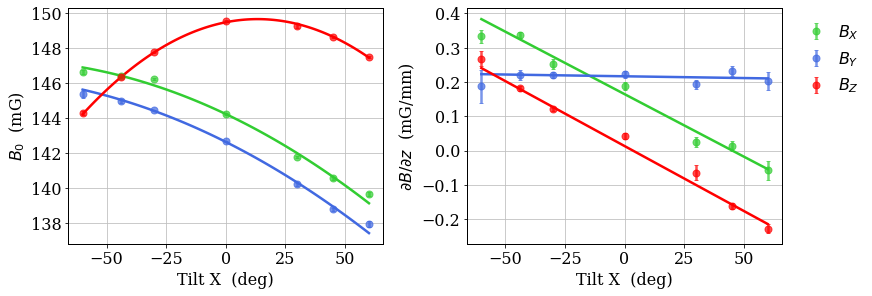

In [5]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,4), constrained_layout=True)

for iax in iaxList:
    PlotOpts['Color']     = RunPars.DefaultPlotColors[iax][0]
    PlotOpts['Linestyle'] = 'None'
    PlotOpts['Marker']    = '.'
    PlotOpts['xLabel']    = 'Tilt X  (deg)'
    PlotOpts['yLabel']    = r'$B_0$  (mG)'
    iXUtils.CustomPlot(axs[0], PlotOpts, TiltX, B0List[iax,0]*1.E3, B0List[iax,1]*1.E3)

    ## Quadratic fit
    pOpt, pCov = np.polyfit(TiltX, B0List[iax,0], deg=2, w=1./B0List[iax,1], full=False, cov=True)
    pErr = np.sqrt(np.diag(pCov))
    pFit = np.poly1d(pOpt)

    print('--------------- Offset fit ---------------')
    print('Curvature = ({:.6f} +/- {:.6f}) mG/deg^2'.format(pOpt[0]*1.E3, pErr[0]*1.E3))
    print('Slope     = ({:.4f} +/- {:.4f}) mG/deg'.format(pOpt[1]*1.E3, pErr[1]*1.E3))
    print('Offset    = ({:.3f} +/- {:.3f}) mG'.format(pOpt[2]*1.E3, pErr[2]*1.E3))

    PlotOpts['Linestyle'] = '-'
    PlotOpts['Marker']    = 'None'
    x = np.linspace(min(TiltX), max(TiltX), num=100, endpoint=True)
    iXUtils.CustomPlot(axs[0], PlotOpts, x, pFit(x)*1E3)

    PlotOpts['Linestyle'] = 'None'
    PlotOpts['Marker']    = '.'
    PlotOpts['yLabel']    = r'$\partial B/\partial z$  (mG/mm)'
    PlotOpts['LegLabel']  = r'$B_'+RunPars.AxisFileLabels[iax]+'$'
    iXUtils.CustomPlot(axs[1], PlotOpts, TiltX, dBList[iax,0]*1.E3, dBList[iax,1]*1.E3)
    axs[1].legend(loc='upper left', bbox_to_anchor=(1.01,1.0))
    PlotOpts['LegLabel']  = None

    ## Linear fit
    pOpt, pCov = np.polyfit(TiltX, dBList[iax,0], deg=1, w=1./dBList[iax,1], full=False, cov=True)
    pErr = np.sqrt(np.diag(pCov))
    pFit = np.poly1d(pOpt)

    print('-------------- Gradient fit --------------')
    print('Slope  = ({:.6f} +/- {:.6f}) mG/mm/deg'.format(pOpt[0]*1.E3, pErr[0]*1.E3))
    print('Offset = ({:.4f} +/- {:.4f}) mG/mm'.format(pOpt[1]*1.E3, pErr[1]*1.E3))

    PlotOpts['Linestyle'] = '-'
    PlotOpts['Marker']    = 'None'
    x = np.sort(TiltX)
    iXUtils.CustomPlot(axs[1], PlotOpts, x, pFit(x)*1E3)

plt.show()

In [15]:
BOffset_Coeffs = np.array([
    [144.239, -0.0647, -0.000338],
    [142.645, -0.0684, -0.000309],
    [149.488, +0.0270, -0.001011]])
BOffset_Coeffs_Err = np.array([
    [0.163, 0.0027, 0.000094],
    [0.089, 0.0019, 0.000068],
    [0.031, 0.0005, 0.000018]])
BGrad_Coeffs = np.array([
    [0.1645, -0.003644],
    [0.2165, -0.000103],
    [0.0132, -0.003788]])
BGrad_Coeffs_Err = np.array([
    [0.0105, 0.000269],
    [0.0052, 0.000162],
    [0.0060, 0.000164]])

tiltX = 57.4
for iax in range(3):
    B  = np.poly1d(BOffset_Coeffs[iax,::-1])
    dB = lambda tiltX: np.sqrt(np.sum([(BOffset_Coeffs_Err[iax,n]*tiltX**n)**2 for n in range(3)]))
    BGrad  = np.poly1d(BGrad_Coeffs[iax,::-1])
    dBGrad = lambda tiltX: np.sqrt(np.sum([(BGrad_Coeffs_Err[iax,n]*tiltX**n)**2 for n in range(2)]))

    print('    B{} = ({:.3f} +/- {:.3f}) mG'.format('x' if iax==0 else 'y' if iax==1 else 'z', B(tiltX), dB(tiltX)))
    print('dB{}/dz = ({:.3f} +/- {:.3f}) mG/mm'.format('x' if iax==0 else 'y' if iax==1 else 'z', BGrad(tiltX), dBGrad(tiltX)))

    Bx = (139.412 +/- 0.383) mG
dBx/dz = (-0.045 +/- 0.019) mG/mm
    By = (137.701 +/- 0.265) mG
dBy/dz = (0.211 +/- 0.011) mG/mm
    Bz = (147.707 +/- 0.073) mG
dBz/dz = (-0.204 +/- 0.011) mG/mm
